In [1]:
import wandb
import numpy as np

# Initialize W&B API client
api = wandb.Api(timeout=29)

# Fetch runs from your project
project_runs = api.runs("ist/llm-baselines")

In [2]:
# Abbrieviations
abbreviations = {
    "NoQuantizer": "NQ",
    "ClipQuantizer": "CQ",
    "HalfHadamardClipQuantizer": "HHCQ",
    "HadamardClipQuantizer": "HCQ",
    "TrustQuantizer": "TQ",
    "HalfHadamardTrustQuantizer": "HHTQ",
    "HadamardTrustQuantizer": "HTQ",
    "GaussianSTEQuantizer": "GSTEQ",
    "GaussianClipQuantizer": "GCQ",
    "GaussianTrustQuantizer": "GTQ",
    "HadamardGaussianClipQuantizer": "HGCQ",
    "HadamaardGaussianTrustQuantizer": "HGTQ",
    "FP4STEQuantizer": "FP4STEQ",
    "FP4ClipQuantizer": "FP4CQ",
    "FP4TrustQuantizer": "FP4TQ",
    "HadamardFP4ClipQuantizer": "HFP4CQ",
    "HalfHadamardFP4TrustQuantizer": "HHFP4TQ",
    "HadamardFP4TrustQuantizer": "HFP4TQ",
    "FourEightMaskedQuantizer": "48BF16",
    "FourEightSTEQuantizer": "48STEQ",
    "FourEightClipQuantizer": "48CQ",
    "FourEightTrustQuantizer": "48TQ",
    "HadamardFourEightTrustQuantizer": "H48TQ",
    "ErfClipQuantizer": "EFCQ",
    
    "PACTQuantizer": "PACT",
}

# Colors
colors = {
    1: "red",
    2: "green",
    2.5: "mediumseagreen",
    3: "blue",
    4: "orange",
    8: "purple",
    16: "black",
}

# Quantizer to linestyle mapping
linestyles = {
    "NoQuantizer": '-',                       # Solid line
    "ClipQuantizer": '--',                     # Dashed line
    "HalfHadamardClipQuantizer": '-.',         # Dotted line
    "HadamardClipQuantizer": '--',             # Dash-dot line
    "TrustQuantizer": ':',                     # Dotted line
    "HalfHadamardTrustQuantizer": '-.',        # Dash-dot line
    "HadamardTrustQuantizer": ':',             # Solid line
    "GaussianSTEQuantizer": '-.',              # Dashed line
    "GaussianClipQuantizer": '--',             # Dash-dot line
    "GaussianTrustQuantizer": ':',             # Dotted line
    "HadamardGaussianClipQuantizer": '-',      # Solid line
    "HadamaardGaussianTrustQuantizer": ':',    # Dashed line
    "FP4STEQuantizer": '-.',                    # Dash-dot line
    "FP4ClipQuantizer": '--',                    # Dotted line
    "FP4TrustQuantizer": ':',                   # Solid line
    "HadamardFP4ClipQuantizer": '--',           # Dashed line
    "HalfHadamardFP4TrustQuantizer": ':',
    "HadamardFP4TrustQuantizer": ':',          # Dash-dot line
    "FourEightMaskedQuantizer": '-',            # Solid line
    "FourEightSTEQuantizer": '-.',               # Dotted line
    "FourEightClipQuantizer": '--',             # Dashed line
    "FourEightTrustQuantizer": ':',            # Dash-dot line
    "HadamardFourEightTrustQuantizer": ':',  # Custom dash pattern
    
    "PACTQuantizer": "-.",
}

# Quantizer to marker mapping
markers = {
    "NoQuantizer": 'o',                         # Circle
    "ClipQuantizer": 's',                       # Square
    "HalfHadamardClipQuantizer": 'D',           # Diamond
    "HadamardClipQuantizer": 'D',               # Diamond
    "TrustQuantizer": 's',                      # Triangle Up
    "HalfHadamardTrustQuantizer": 'D',          # Diamond
    "HadamardTrustQuantizer": 'D',              # Plus Filled
    "GaussianSTEQuantizer": 'X',                # Triangle Down
    "GaussianClipQuantizer": 'X',               # X Marker
    "GaussianTrustQuantizer": 'X',              # Hexagon
    "HadamardGaussianClipQuantizer": '+',       # Star Marker
    "HadamardGaussianTrustQuantizer": '+',     # Star Marker
    "FP4STEQuantizer": '<',                     # Tri Down Marker
    "FP4ClipQuantizer": '<',                    # Tri Up Marker
    "FP4TrustQuantizer": '<',                   # Tri Left Marker
    "HalfHadamardFP4TrustQuantizer": 'X',       # Tri Left Marker
    "HadamardFP4ClipQuantizer": '>',            # Tri Right Marker
    "HadamardFP4TrustQuantizer": '>',           # Plus Marker
    "FourEightMaskedQuantizer": 'v',            # Hexagon1 Marker
    "FourEightSTEQuantizer": 'v',               # Hexagon1 Marker
    "FourEightClipQuantizer": 'v',              # Triangle Down Marker
    "FourEightTrustQuantizer": 'v',             # Diamond Marker
    "HadamardFourEightTrustQuantizer": '^',     # Star Marker
    
    "PACTQuantizer": "+",
}


In [3]:
all_runs = []

# Iterate over runs and extract confusion matrix data
for run in project_runs:
    # This is a placeholder; you'll need to adjust it based on how you've logged your data
    
    model_size = int(run.name.split("-")[1][:-1]) if not run.name[0].isnumeric() else int(run.name.split("-")[0][:-1])
    loss = run.summary.get('final-val/loss')
    quant = run.config.get("w_quant")
    w_quant_arg = run.config.get("w_quant_kwargs")
    a_quant_arg = run.config.get("a_quant_kwargs")
    dataset = run.config.get("dataset")
    lr = run.config.get("lr")
    
    if loss is not None and dataset is not None and dataset == "c4":
        tokens = run.config["iterations"] * run.config["batch_size"] * run.config["sequence_length"] * run.config["acc_steps"] * run.config["world_size"]
        non_embedding_parameters = run.summary["non_embedding_parameters"]
        
        if model_size == 100 and lr != 0.0006 and w_quant_arg is not None and w_quant_arg['bits'] in [1, 2]: 
            continue
        
        if model_size == 200 and lr == 0.00003:
            continue
        
        if run.config.get("vocab_size") == 32000:
            continue
        
        all_runs.append({
            'model_size': model_size, #12 * run.config['n_layer'] * run.config['n_embd'] ** 2 * 1e-6
            'w_bits': w_quant_arg['bits'] if w_quant_arg is not None else 16,
            'a_bits': a_quant_arg['bits'] if a_quant_arg is not None else 16,
            'loss': loss,
            'tokens': tokens,
            'bops': non_embedding_parameters * tokens,
            'w_quant': quant,
            'a_quant': run.config["a_quant"],
            'trust': w_quant_arg.get("trust") if w_quant_arg is not None else None,
            'p': w_quant_arg.get("p") if w_quant_arg is not None else None,
            'clip_scale': w_quant_arg.get("clip_scale") if w_quant_arg is not None else None,
        })


In [4]:
runs_for_scaling = [
    {
        "L": run["loss"],
        "N": run["model_size"] * 1e6,
        "P": run["w_bits"] if run["w_quant"] != "NoQuantizer" else 16,
        "D": run["tokens"],
        "C": run["bops"],
    } 
    for run in all_runs if (
        run['w_quant'] == "HadamardTrustQuantizer" and run['a_quant'] == "HadamardTrustQuantizer" and run['trust'] is None and run['a_bits'] != 1 and run['a_bits'] == run['w_bits']
    ) or (
        run['w_quant'] == "HadamardClipQuantizer" and run['a_quant'] == "HadamardClipQuantizer" and run['clip_scale'] == 1.30 and run['a_bits'] == 1 and run['a_bits'] == run['w_bits']
    ) or (
        run['w_quant'] == "NoQuantizer" and run['a_quant'] == "NoQuantizer"
    ) or (
        run["w_quant"] == "HalfHadamardTrustQuantizer" and run["a_quant"] == "HalfHadamardTrustQuantizer" and run["a_bits"] == run["w_bits"] and run["a_bits"] != 1.585
    ) or (
        run["w_quant"] == "HalfHadamardClipQuantizer" and run["a_quant"] == "HalfHadamardClipQuantizer" and run["clip_scale"] == 1.30 and run["w_bits"] == 1 and run["a_bits"] == 1
    )
]

runs_for_scaling.extend([
    {
        "L": run["loss"],
        "N": run["model_size"] * 1e6,
        "P": 2.50,
        "D": run["tokens"],
        "C": run["bops"],
    }
    for run in all_runs if (
        run['w_quant'] == "HadamardFourEightTrustQuantizer" and run['a_quant'] == "HadamardTrustQuantizer" and run['trust'] is None
    )
])

runs_for_scaling.extend([
    {
        "L": run["loss"],
        "N": run["model_size"] * 1e6,
        "P": "fp4",
        "D": run["tokens"],
        "C": run["bops"],
    }
    for run in all_runs if (
        run['w_quant'] == "HalfHadamardFP4TrustQuantizer" and run['a_quant'] == "HalfHadamardFP4TrustQuantizer" and run['trust'] is None and run['w_bits'] == run['a_bits']
    )
])

runs_for_scaling.extend([
    {
        "L": run["loss"],
        "N": run["model_size"] * 1e6,
        "P": f"{run['w_bits']}NOH",
        "D": run["tokens"],
        "C": run["bops"],
    }
    for run in all_runs if (
        run['w_quant'] == "TrustQuantizer" and run['a_quant'] == "TrustQuantizer" and run['trust'] is None and run['w_bits'] == run['a_bits'] and run['w_bits'] != 1
    ) or (
        run['w_quant'] == "ClipQuantizer" and run['a_quant'] == "ClipQuantizer" and run['clip_scale'] == 1.25 and run['w_bits'] == run['a_bits'] and run['w_bits'] == 1
    )
])

runs_for_scaling.extend([
    {
        "L": run["loss"],
        "N": run["model_size"] * 1e6,
        "P": f"{run['w_bits']}WO",
        "D": run["tokens"],
        "C": run["bops"],
    }
    for run in all_runs if (
        run['w_quant'] == "HalfHadamardTrustQuantizer" and run['a_quant'] == "NoQuantizer" and run['trust'] is None and run['w_bits'] != 1
    ) or (
        run['w_quant'] == "HalfHadamardClipQuantizer" and run['a_quant'] == "NoQuantizer" and run['clip_scale'] == 1.3 and run['w_bits'] == 1
    )
])

class DotDict(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{key}'")

    def __setattr__(self, key, value):
        self[key] = value

In [5]:
REFIT = False

import numpy as np
from scipy.optimize import least_squares

from tqdm.auto import tqdm

# Example data
data = runs_for_scaling

def model(params, N, D, P):
    """
    Given parameter vector and one data point (N, D, P),
    return the predicted L.
    """
    # Unpack parameters
    a, alpha, b, beta, e, \
    eff1, eff2, eff3, eff4, eff8, \
    effnoh1, effnoh1585, effnoh2, effnoh3, effnoh4, effnoh8, \
    effwo1, effwo2, effwo3, effwo4, \
    eff48, efffp4 = params
    
    # Define eff(16) = 1.0 (fixed)
    def eff(p):
        if p == 1: return eff1
        elif p == 2: return eff2
        elif p == 2.5: return eff48
        elif p == 3: return eff3
        elif p == 4: return eff4
        elif p == 8: return eff8
        elif p == 16: return 1.0
        elif p == "fp4": return efffp4
        elif p == "1NOH": return effnoh1
        elif p == "1.585NOH": return effnoh1585
        elif p == "2NOH": return effnoh2
        elif p == "3NOH": return effnoh3
        elif p == "4NOH": return effnoh4
        elif p == "8NOH": return effnoh8
        elif p == "1WO": return effwo1
        elif p == "2WO": return effwo2
        elif p == "3WO": return effwo3
        elif p == "4WO": return effwo4
        else:
            raise ValueError(f"Unknown p: {p}")

    # The scaling law:
    #   L(N, D, P) = A / [ (N * eff(P))^alpha ] + B / [ D^beta ] + E
    return (np.exp(a) / ((N * eff(P)) ** alpha)) + (np.exp(b) / (D ** beta)) + np.exp(e)

def log_residuals(params, data):
    """
    Residuals in log-space: log(L_i) - log(model_prediction).
    We'll apply a robust loss (Huber) to these via least_squares(..., loss='huber').
    """
    residual_list = []
    for point in data:
        # Avoid numerical issues: ensure model(...) > 0 before log
        L_model = model(params, point['N'], point['D'], point['P'])
        if L_model <= 0:
            # If the model predicts a non-positive value, penalize it heavily
            r = 1
        else:
            r = (np.log(point['L']) - np.log(L_model)) * 1e-3
        residual_list.append(r)
    return np.array(residual_list)

a_grid = [5, 10, 15, 20, 25]
alpha_grid = [0.0, 0.5, 1.0]
b_grid = [5, 10, 15, 20, 25]
beta_grid = [0.0, 0.5, 1.0]
e_grid = [-1, -0.5, 0.0, 0.5, 1.0]

best_result = None
best_cost = np.inf

if REFIT:
    for a0 in tqdm(a_grid, desc="a0"):
        for alpha0 in tqdm(alpha_grid, leave=False, desc="alpha0"):
            for b0 in tqdm(b_grid, leave=False, desc="b0"):
                for beta0 in beta_grid:
                    for e0 in e_grid:
                        
                        initial_guess = [a0, alpha0, b0, beta0, e0,
                                         0.1, 0.3, 0.5, 0.8, 0.9,
                                         0.1, 0.2, 0.3, 0.5, 0.8, 0.9,
                                         0.5, 0.6, 0.7, 0.8,
                                         0.3, 0.5]
                        
                        result = least_squares(
                            fun=log_residuals,
                            x0=initial_guess,
                            args=(data,),
                            loss='huber',
                            f_scale=1.0
                        )
                        
                        if result.cost < best_cost:
                            best_cost = result.cost
                        best_result = result

    a_fit, alpha_fit, b_fit, beta_fit, e_fit, \
    eff1_fit, eff2_fit, eff3_fit, eff4_fit, eff8_fit, \
    effnoh1_fit, effnoh1585_fit, effnoh2_fit, effnoh3_fit, effnoh4_fit, effnoh8_fit, \
    effwo1_fit, effwo2_fit, effwo3_fit, effwo4_fit, \
    eff48_fit, efffp4_fit = best_result.x
else:
    best_result = DotDict({"x": [ 2.10177288e+00,  6.30207964e-02,  4.42547733e+00,  2.40347572e-01,
       -5.32487858e+00,  2.21845438e-02,  1.53401014e-01,  4.34999849e-01,
        6.90075965e-01,  1.02694727e+00,  1.61716497e-02, -2.16181436e+01,
        8.04368016e-02,  3.29524007e-01,  6.16882123e-01,  9.49987359e-01,
        1.41594081e-01,  4.17338047e-01,  6.54655600e-01,  8.42677640e-01,
        3.90429555e-01,  6.39209424e-01], "cost": 1.021798657286814e-09})
    a_fit, alpha_fit, b_fit, beta_fit, e_fit, \
    eff1_fit, eff2_fit, eff3_fit, eff4_fit, eff8_fit, \
    effnoh1_fit, effnoh1585_fit, effnoh2_fit, effnoh3_fit, effnoh4_fit, effnoh8_fit, \
    effwo1_fit, effwo2_fit, effwo3_fit, effwo4_fit, \
    eff48_fit, efffp4_fit = best_result.x

A_fit = np.exp(a_fit)
B_fit = np.exp(b_fit)

print("Best fitted parameters (via log-residual + Huber) from the sweep:")
print(f"  A       = {A_fit}")
print(f"  alpha   = {alpha_fit}")
print(f"  B       = {B_fit}")
print(f"  beta    = {beta_fit}")
print(f"  E       = {np.exp(e_fit)}")
print(f"  eff(1)  = {eff1_fit}")
print(f"  eff(2)  = {eff2_fit}")
print(f"  eff(3)  = {eff3_fit}")
print(f"  eff(4)  = {eff4_fit}")
print(f"  eff(8)  = {eff8_fit}")
print(f"  eff(fp4)= {efffp4_fit}")
print(f"  eff(2.5)= {eff48_fit}")
print(f"  eff(1NOH)  = {effnoh1_fit}")
print(f"  eff(2NOH)  = {effnoh2_fit}")
print(f"  eff(3NOH)  = {effnoh3_fit}")
print(f"  eff(4NOH)  = {effnoh4_fit}")
print(f"  eff(8NOH)  = {effnoh8_fit}")
print(f"  eff(1WO)  = {effwo1_fit}")
print(f"  eff(2WO)  = {effwo2_fit}")
print(f"  eff(3WO)  = {effwo3_fit}")
print(f"  eff(4WO)  = {effwo4_fit}")
print("  eff(16) = 1.0 (fixed)")
print("-" * 40)
print("Lowest loss: ", best_result.cost)


Best fitted parameters (via log-residual + Huber) from the sweep:
  A       = 8.180660393028319
  alpha   = 0.0630207964
  B       = 83.55267990576948
  beta    = 0.240347572
  E       = 0.004868942165297967
  eff(1)  = 0.0221845438
  eff(2)  = 0.153401014
  eff(3)  = 0.434999849
  eff(4)  = 0.690075965
  eff(8)  = 1.02694727
  eff(fp4)= 0.639209424
  eff(2.5)= 0.390429555
  eff(1NOH)  = 0.0161716497
  eff(2NOH)  = 0.0804368016
  eff(3NOH)  = 0.329524007
  eff(4NOH)  = 0.616882123
  eff(8NOH)  = 0.949987359
  eff(1WO)  = 0.141594081
  eff(2WO)  = 0.417338047
  eff(3WO)  = 0.6546556
  eff(4WO)  = 0.84267764
  eff(16) = 1.0 (fixed)
----------------------------------------
Lowest loss:  1.021798657286814e-09


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
main_sequence_runs = [run for run in all_runs if abs(run['tokens'] / run['model_size'] / 1e6  - 100) < 10]

In [29]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['font.family'] = "Times New Roman"
LABEL_SIZE = 16
plt.rcParams['axes.labelsize'] = LABEL_SIZE
LEGEND_SIZE = 16
plt.rcParams['legend.fontsize'] = LEGEND_SIZE
AXIS_LABEL_SIZE = 12
plt.rcParams['xtick.labelsize'] = AXIS_LABEL_SIZE  # Set x-axis tick label size
plt.rcParams['ytick.labelsize'] = AXIS_LABEL_SIZE  # Set y-axis tick label size

def plot_quantizer(runs, w_bits, w_quantizer, a_bits=None, a_quantizer=None, alpha=1, extra_filter=lambda run: True, bits_fn=lambda bits: bits, label=None,
                   plot_kwargs=None, draw_scaling_law=False, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if a_quantizer is None:
        a_quantizer = w_quantizer
    if a_bits is None:
        a_bits = w_bits
        
    filtered_runs = [
        run for run in runs if 
        run['w_bits'] == w_bits and 
        run['w_quant'] == w_quantizer and
        run['a_quant'] == a_quantizer and 
        extra_filter(run)
    ]
    
    if a_quantizer != "NoQuantizer":
        filtered_runs = [
            run for run in filtered_runs if 
            run['a_bits'] == a_bits
        ]
        
    losses = {run['model_size'] * bits_fn(w_bits): run['loss'] for run in filtered_runs}
    data = [x for _, x in sorted(losses.items())]
    memory = sorted(losses.keys())
    
    updated_plot_kwargs = {
        "label": f"{abbreviations[w_quantizer]}@{w_bits}bit" if label is None else label,
        "color": colors[w_bits],
        "marker": markers[w_quantizer],
        "alpha": alpha,
        "linestyle": linestyles[w_quantizer],
    }
    if plot_kwargs is not None:
        updated_plot_kwargs.update(plot_kwargs)
    
    if draw_scaling_law:
        model_sizes = sorted([run['model_size'] for run in filtered_runs])
        sizes_grid = np.linspace(min(model_sizes), max(max(model_sizes), min(model_sizes) * 2), 50)
        
        if w_quantizer == "HalfHadamardFP4TrustQuantizer":
            precision = "fp4"
        elif w_quantizer == "TrustQuantizer" or w_quantizer == "ClipQuantizer":
            precision = f"{bits_fn(w_bits)}NOH"
        elif a_quantizer == "NoQuantizer":
            precision = f"{bits_fn(w_bits)}WO"
        else:
            precision = bits_fn(w_bits)
        
        ax.plot(
            [n * bits_fn(w_bits) for n in sizes_grid],
            [model(
                best_result.x, n * 1e6, n * 1e8, 
                precision,
            ) for n in sizes_grid],
            color=updated_plot_kwargs['color'], linestyle=updated_plot_kwargs['linestyle'], alpha=alpha, marker=None
        )
        
        del updated_plot_kwargs['linestyle']
        ax.scatter(memory, data, **updated_plot_kwargs)
    else:
        ax.plot(memory, data, **updated_plot_kwargs)
    

def plot_bf16(runs, draw_scaling_law=False, ax=None):
    if ax is None:
        ax = plt.gca()
    losses = [run['loss'] for run in runs if run['w_quant'] == "NoQuantizer" and run['a_quant'] == "NoQuantizer"]
    memory = [run['model_size'] * 16 for run in runs if run['w_quant'] == "NoQuantizer" and run['a_quant'] == "NoQuantizer"]
    data = [x for _, x in sorted(zip(memory, losses))]
    memory = sorted(memory)
    if draw_scaling_law:
        ax.scatter(memory, data, label=f"BF16", color=colors[16], marker=markers["NoQuantizer"])
        model_sizes = sorted([run['model_size'] for run in runs])
        sizes_grid = np.linspace(min(model_sizes), max(max(model_sizes), min(model_sizes) * 2), 50)
        ax.plot(
            [n * 16 for n in sizes_grid],
            [model(best_result.x, n * 1e6, n * 1e8, 16) for n in sizes_grid],
            color=colors[16], linestyle=linestyles["NoQuantizer"]
        )
    else:
        ax.plot(memory, data, label=f"BF16", color=colors[16], linestyle=linestyles["NoQuantizer"], marker=markers["NoQuantizer"])
    
def set_scaling_law_bounds(
    xlim=(25, 10000),
    ylim=(2.5, 4.3),
    xlabel="Memory, Mbit",
    ylabel="C4 Val Loss",
    ax=None,
):
    if ax is None:
        ax = plt.gca()
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    ax.set_xscale("log")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(fontsize=None)

Text(0, 0.5, 'C4 Val Loss')

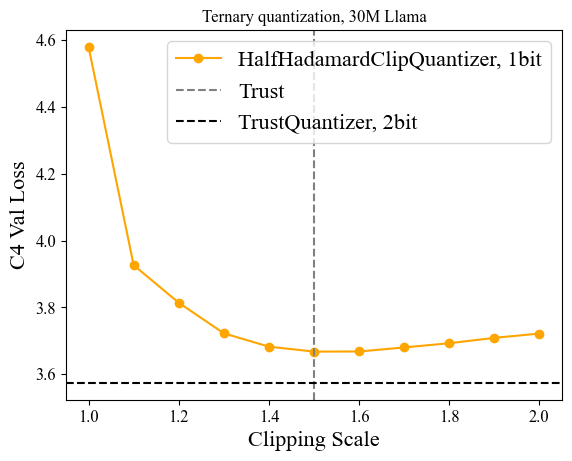

In [8]:
# HadamardClipQuantizer
clip_scale_losses = {run['clip_scale']: run['loss'] for run in main_sequence_runs if run['w_quant'] == 'HalfHadamardClipQuantizer' and run['clip_scale'] is not None and int(run['model_size']) == 30 and run['w_bits'] == 1.585 and run['a_bits'] == 1.585}
plt.plot(sorted(clip_scale_losses.keys()), [clip_scale_losses[clip_scale] for clip_scale in sorted(clip_scale_losses.keys())], color="orange", marker="o", label="HalfHadamardClipQuantizer, 1bit")

plt.axvline(1.5, linestyle="--", color="grey", label="Trust")

# TrustQuantizer, 2bit
plt.axhline([run['loss'] for run in main_sequence_runs if int(run['model_size']) == 30 and run['w_quant'] == 'HadamardTrustQuantizer' and run['w_bits'] == 2 and run['a_bits'] == 2 and run['trust'] is None][0], linestyle="--", color="black", label="TrustQuantizer, 2bit")

plt.legend()
plt.title("Ternary quantization, 30M Llama")
plt.xlabel("Clipping Scale")
plt.ylabel("C4 Val Loss")

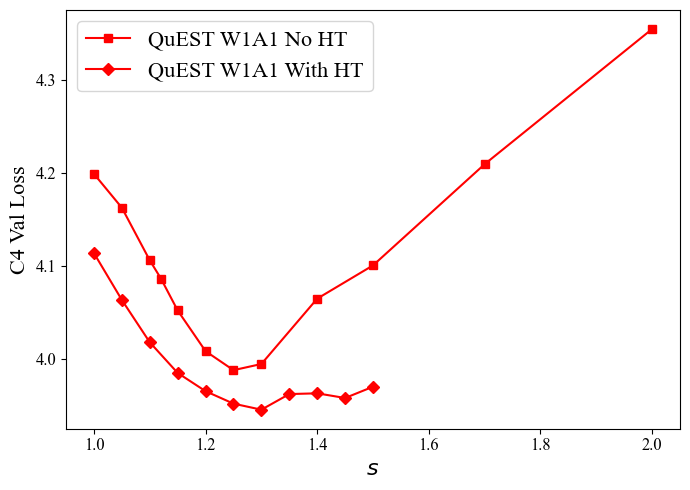

In [9]:
# ClipQuantizer
plt.figure(figsize=(7, 5))

clip_scale_losses = {run['clip_scale']: run['loss'] for run in main_sequence_runs if run['w_quant'] == 'ClipQuantizer' and run['a_quant'] == 'ClipQuantizer' and run['clip_scale'] is not None and int(run['model_size']) == 30 and run['w_bits'] == 1 and run['a_bits'] == 1}
clip_scale_losses[2] = [run['loss'] for run in main_sequence_runs if int(run['model_size']) == 30 and run['w_quant'] == 'TrustQuantizer' and run['a_quant'] == 'TrustQuantizer' and run['w_bits'] == 1 and run['a_bits'] == 1][0]
plt.plot(sorted(clip_scale_losses.keys()), [clip_scale_losses[clip_scale] for clip_scale in sorted(clip_scale_losses.keys())], 
         color=colors[1], marker=markers["TrustQuantizer"], label="QuEST W1A1 No HT")

# HadamardClipQuantizer
clip_scale_losses = {run['clip_scale']: run['loss'] for run in main_sequence_runs if run['w_quant'] == 'HadamardClipQuantizer' and run['clip_scale'] is not None and int(run['model_size']) == 30 and run['w_bits'] == 1 and run['a_bits'] == 1}
# clip_scale_losses[2] = [run['loss'] for run in runs if int(run['model_size']) == 30 and run['w_quant'] == 'HadamardTrustQuantizer' and run['w_bits'] == 1 and run['a_bits'] == 1][0]
plt.plot(sorted(clip_scale_losses.keys()), [clip_scale_losses[clip_scale] for clip_scale in sorted(clip_scale_losses.keys())],
         color=colors[1], marker=markers["HadamardTrustQuantizer"], label="QuEST W1A1 With HT")

# HadamardTrustQuantizer, 2bit
# plt.axhline([run['loss'] for run in main_sequence_runs if int(run['model_size']) == 30 and run['w_quant'] == 'HadamardTrustQuantizer' and run['w_bits'] == 2 and run['a_bits'] == 2 and run['trust'] is None][0], linestyle="--", color="black", label="HTQ, 2bit")

plt.legend()
plt.xlabel("$s$")
plt.ylabel("C4 Val Loss")
plt.tight_layout()
plt.savefig("../figures/trust_scale.pdf", bbox_inches="tight")
plt.show()

# Main Plot

In [10]:
to_run = {
    # Weight-only
    # "ClipQuantizer@1:BF16": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@2:BF16": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@3:BF16": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@4:BF16": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@8:BF16": ["30M", "50M", "100M", "200M"],
    # Combinations
    # "TrustQuantizer@1:TrustQuantizer@4": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@1:TrustQuantizer@8": ["30M", "50M", "100M", "200M"],
    # "TrustQuantizer@2:TrustQuantizer@4": ["30M", "50M", "100M", "200M"],
    # 800M
    # "BF16:BF16": ["800M"], # RUNNING
    "HadamardFourEightTrustQuantizer@4:HadamardTrustQuantizer@4": ["800M"],
    # "HadamardTrustQuantizer@4:HadamardTrustQuantizer@4": ["800M"],
    # "HadamardClipQuantizer@1:HadamardClipQuantizer@1": ["800M"],
}

worst_case_runtimes_hrs = {"30M": 0.33, "50M": 1.0, "100M": 4.0, "200M": 13.0, "800M": 60.0}

worst_sum = 0
for key, values in to_run.items():
    for value in values:
        worst_sum += worst_case_runtimes_hrs[value]
        
print(f"Worst runtume: {worst_sum / 24} node days")

Worst runtume: 2.5 node days


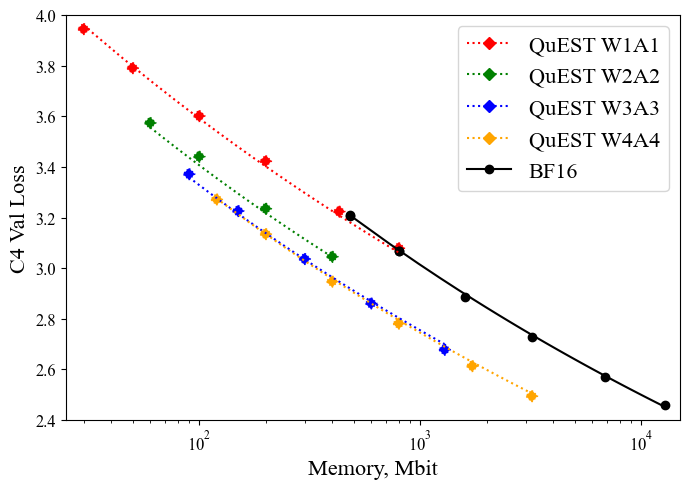

In [11]:
plt.figure(figsize=(7, 5))
plot_quantizer(main_sequence_runs, 1, "HadamardClipQuantizer", extra_filter=lambda run: run['clip_scale'] == 1.30,
               plot_kwargs={"label": "QuEST W1A1", "linestyle": linestyles["HadamardTrustQuantizer"]}, draw_scaling_law=True)

for i, bits in enumerate([2, 3, 4]):
    plot_quantizer(main_sequence_runs, bits, "HadamardTrustQuantizer", extra_filter=lambda run: run['trust'] is None, plot_kwargs={"label": f"QuEST W{bits}A{bits}"}, draw_scaling_law=True)
    
    
# plot_quantizer(main_sequence_runs, 3, "PACTQuantizer", 3, "PACTQuantizer", plot_kwargs={"label": f"PACT W3A3"})
# plot_quantizer(main_sequence_runs, 4, "PACTQuantizer", 4, "PACTQuantizer", plot_kwargs={"label": f"PACT W4A4"})
    
plot_bf16(main_sequence_runs, draw_scaling_law=True)
# set_scaling_law_bounds(xlim=(25, 5000), ylim=(2.55, 4.0), legend_fontsize=12)
set_scaling_law_bounds(xlim=(25, 1.5e4), ylim=(2.4, 4.0))


plt.legend(handles=[
    mlines.Line2D(
        [], [], 
        color=colors[bits],
        marker=markers["HadamardTrustQuantizer"],
        linestyle=linestyles["HadamardTrustQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"QuEST W{bits}A{bits}",
    ) for bits in [1, 2, 3, 4]
] + [
    mlines.Line2D(
        [], [], 
        color=colors[16],
        marker=markers["NoQuantizer"],
        linestyle=linestyles["NoQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"BF16",
    )
])

plt.tight_layout()
plt.savefig("../figures/main.pdf", bbox_inches='tight')
plt.show()

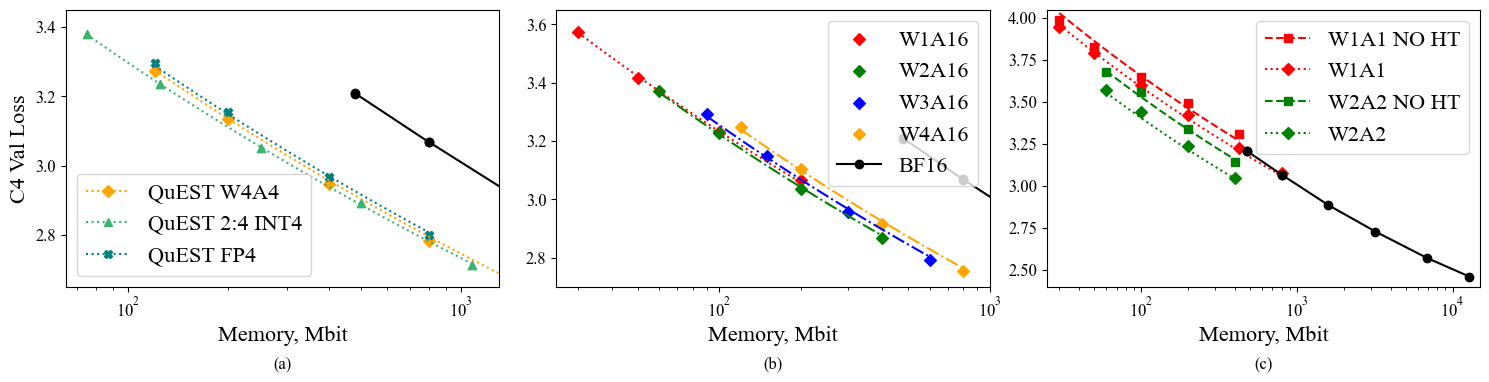

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

# HadamardFourEightTrustQuantizer
ax = axs[0]

plot_quantizer(main_sequence_runs, 4, "HadamardTrustQuantizer", 4, "HadamardTrustQuantizer", 
               ax=ax, plot_kwargs={"label": "W4A4"}, draw_scaling_law=True)
plot_quantizer(main_sequence_runs, 4, "HadamardFourEightTrustQuantizer", 4, "HadamardTrustQuantizer", 
               bits_fn=lambda bits: (bits / 2 + 0.5), ax=ax, plot_kwargs={"label": "2:4 Int4", "color": colors[2.5]}, draw_scaling_law=True)
plot_quantizer(main_sequence_runs, 16, "HalfHadamardFP4TrustQuantizer", 16, "HalfHadamardFP4TrustQuantizer", 
               ax=ax, bits_fn=lambda _: 4, plot_kwargs={"label": "FP4", "color": "teal"}, draw_scaling_law=True)
    
plot_bf16(main_sequence_runs, ax=ax)
set_scaling_law_bounds(xlim=(65, 1300), ylim=(2.65, 3.45), ax=ax)
ax.legend(handles=[
    mlines.Line2D(
        [], [], 
        color=colors[4],
        marker=markers["HadamardTrustQuantizer"],
        linestyle=linestyles["HadamardTrustQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"QuEST W4A4",
    ),
    mlines.Line2D(
        [], [], 
        color=colors[2.5],
        marker=markers["HadamardFourEightTrustQuantizer"],
        linestyle=linestyles["HadamardFourEightTrustQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"QuEST 2:4 INT4",
    ),
    mlines.Line2D(
        [], [], 
        color="teal",
        marker=markers["HalfHadamardFP4TrustQuantizer"],
        linestyle=linestyles["HalfHadamardFP4TrustQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"QuEST FP4",
    ),
])


# Weight-only
ax = axs[1]

plot_quantizer(main_sequence_runs, 1, "HalfHadamardClipQuantizer", None, "NoQuantizer", extra_filter=lambda run: run['clip_scale'] == 1.30,
               plot_kwargs={"linestyle": linestyles["TrustQuantizer"], "label": "W1A16"}, ax=ax, draw_scaling_law=True)

for i, bits in enumerate([2, 3, 4]):
    plot_quantizer(main_sequence_runs, bits, "HalfHadamardTrustQuantizer", None, "NoQuantizer",
                   plot_kwargs={"label": f"W{bits}A16"}, ax=ax, draw_scaling_law=True)
    
# plot_quantizer(main_sequence_runs, 4, "PACTQuantizer", None, "NoQuantizer", plot_kwargs={"label": f"PACT W4A16"}, ax=ax)
# plot_quantizer(main_sequence_runs, 3, "PACTQuantizer", None, "NoQuantizer", plot_kwargs={"label": f"PACT W3A16"}, ax=ax)
    
plot_bf16(main_sequence_runs, ax=ax)
set_scaling_law_bounds(xlim=(25, 1000), ylim=(2.7, 3.65), ylabel=None, ax=ax)

# TrustQuantzier
ax = axs[2]

plot_quantizer(main_sequence_runs, 1, "ClipQuantizer", extra_filter=lambda run: run['clip_scale'] == 1.25,
               plot_kwargs={"linestyle": "--", "label": "W1A1 NO HT"}, ax=ax, draw_scaling_law=True)
plot_quantizer(main_sequence_runs, 1, "HadamardClipQuantizer", extra_filter=lambda run: run['clip_scale'] == 1.30,
               plot_kwargs={"linestyle": linestyles["HadamardTrustQuantizer"], "label": "W1A1"}, ax=ax, draw_scaling_law=True)

for i, bits in enumerate([2]):
    plot_quantizer(main_sequence_runs, bits, "TrustQuantizer", extra_filter=lambda run: run['trust'] is None, 
                   plot_kwargs={"linestyle": "--", "label": f"W{bits}A{bits} NO HT"}, ax=ax, draw_scaling_law=True)
    plot_quantizer(main_sequence_runs, bits, "HadamardTrustQuantizer", extra_filter=lambda run: run['trust'] is None,
                   plot_kwargs={"label": f"W{bits}A{bits}"}, ax=ax, draw_scaling_law=True)
    
plot_bf16(main_sequence_runs, ax=ax)
set_scaling_law_bounds(xlim=(25, 1.5e4), ylim=(2.4, 4.05), ylabel=None, ax=ax)

handles = [
    mlines.Line2D(
        [], [], 
        color=colors[bits],
        marker=markers["HadamardTrustQuantizer"],
        linestyle=linestyles["HadamardTrustQuantizer"],
        markersize=6,   # adjust as you prefer
        label=f"W{bits}A{bits}",
    ) for bits in [1, 2]
] + [
    mlines.Line2D(
        [], [], 
        color=colors[bits],
        marker=markers["TrustQuantizer"],
        linestyle="--",
        markersize=6,   # adjust as you prefer
        label=f"W{bits}A{bits} NO HT",
    ) for bits in [1, 2]
]
handles = [handles[i] for i in [2, 0, 3, 1]]
plt.legend(handles=handles)

# a b c
labels = ['(a)', '(b)', '(c)']
for ax, label in zip(axs, labels):
    ax.annotate(label, 
                xy=(0.5, -0.25),     # x=0.5 (center), y=-0.25 (below the x-axis)
                xycoords='axes fraction',
                ha='center', 
                va='top', 
                fontsize=12)


# SAVE
fig.tight_layout()
fig.savefig("../figures/extra.pdf", bbox_inches='tight')

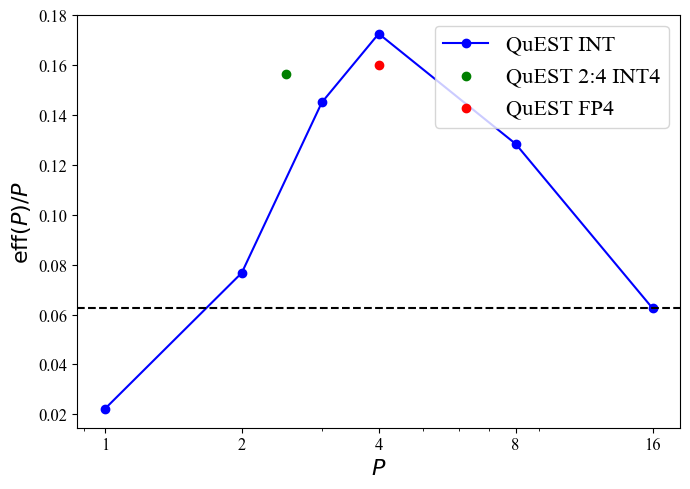

In [13]:
efficiencies_linear = {
    1: float(eff1_fit * 16 / 1),
    2: float(eff2_fit * 16 / 2),
    3: float(eff3_fit * 16 / 3),
    4: float(eff4_fit * 16 / 4),
    8: float(eff8_fit * 16 / 8),
    16: 1,
}

efficiencies_max_4090 = {
    1: float(eff1_fit * 32),
    2.5: float(eff48_fit * 16),
    4: float(eff4_fit * 8),
    8: float(eff8_fit * 4),
    16: 1,
}

plt.figure(figsize=(7, 5))
bits = sorted(efficiencies_linear.keys())
values = [efficiencies_linear[bit] / 16 for bit in bits]
plt.plot(bits, values, marker="o", label=r"QuEST INT", color="blue")

plt.scatter([2.5], [eff48_fit / 2.5], label="QuEST 2:4 INT4", color="green")
plt.scatter([4], [efffp4_fit / 4], label="QuEST FP4", color="red")

# bits_4090 = sorted(efficiencies_max_4090.keys())
# values_4090 = [efficiencies_max_4090[bit] for bit in bits_4090]
# plt.plot(bits_4090, values_4090, marker="o", label="TOPS, RTX4090", color="red", linestyle="--")

# x_val = 2.5
# y_val = efficiencies_max_4090[x_val]  # This should be eff48_fit * 16

# plt.annotate(
#     "2:4 Int4",                   # The text to display
#     xy=(x_val, y_val),            # The data point to label
#     xytext=(0, 10),               # Offset (in points) from the point
#     textcoords="offset points",   
#     ha="center",                  # Horizontal alignment of the text
#     color="red",                  # Text color
#     fontsize=12,
#     # arrowprops=dict(arrowstyle="->", color="red")  # Optional arrow
# )


plt.axhline(1/16, color="black", linestyle="--")

plt.xscale("log")

plt.xlabel("$P$")
plt.ylabel(r"$\text{eff}(P)/P$")
plt.ylim(None, None)

ticks = [1, 2, 4, 8, 16]
plt.xticks(ticks, ticks)

plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("../figures/efficiencies.pdf", bbox_inches='tight')

In [14]:
grid_mses = {1: np.float64(0.3633802276324186),
 2: np.float64(0.11884605038769407),
 3: np.float64(0.03743965939152373),
 4: np.float64(0.011542884500323213),
 8: np.float64(8.782117814336654e-05),
}

fp4_mse = np.float64(0.012684904138719949)

eff_fits = {
    1: eff1_fit,
    2: eff2_fit,
    3: eff3_fit,
    4: eff4_fit,
    8: eff8_fit,
}

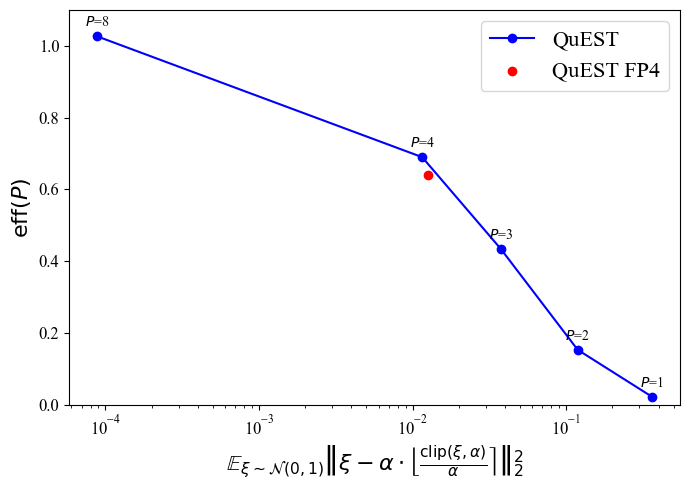

In [15]:
import matplotlib.pyplot as plt

# Your original plot
plt.figure(figsize=(7, 5))

plt.plot(grid_mses.values(), eff_fits.values(), 
         marker="o", label=r"QuEST", color="blue")
plt.scatter([fp4_mse], [efffp4_fit], 
            label="QuEST FP4", color="red")

plt.xscale("log")
plt.xlabel(r"$\mathbb{E}_{\xi\sim\mathcal{N}(0, 1)} \left\|\xi - \alpha \cdot \left\lfloor\frac{\text{clip}(\xi, \alpha)}{\alpha}\right\rceil\right\|_2^2$")
plt.ylabel(r"$\text{eff}(P)$")
plt.legend(loc="upper right")
plt.tight_layout()

# ---------------------------
# Add subscripts to each point
# ---------------------------

# If you'd like each point in grid_mses/eff_fits to have a label like P_1, P_2, ...
for i, (mse, eff) in enumerate(zip(grid_mses.values(), eff_fits.values())):
    plt.annotate(
        f"$P$={list(grid_mses.keys())[i]}",        # subscript label, e.g. P_1, P_2, ...
        xy=(mse, eff),         # the point to label
        xytext=(0, 5),         # offset (in points) above the point
        textcoords="offset points",
        ha='center', 
        va='bottom'
    )

plt.ylim(0, 1.1)

plt.savefig("../figures/eff_vs_err.pdf", bbox_inches='tight')
plt.show()


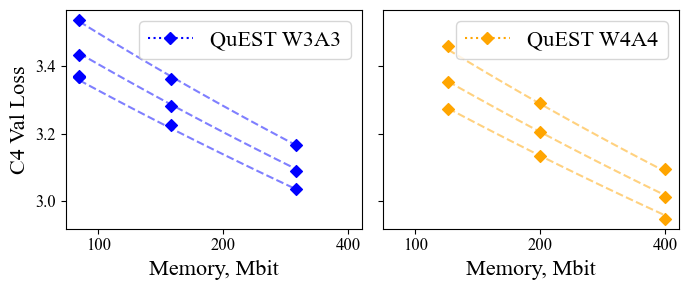

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator

##############################################################################
# 3) Define a function that returns eff(p) and the model(N,D,P)
##############################################################################
def eff(p):
    if p == 1:  return eff1_fit
    if p == 2:  return eff2_fit
    if p == 3:  return eff3_fit
    if p == 4:  return eff4_fit
    if p == 16: return 1.0
    return 1.0  # fallback

##############################################################################
# 4) Group by P, plot L vs. (N*P), and overlay a fitted curve for each group
##############################################################################
# (a) Group data by P
groups = {}
grpup_to_subplot = {3.0: 0, 4.0: 1}
for pt in runs_for_scaling:
    p_val = pt["P"]
    if p_val not in grpup_to_subplot:
        continue
    if pt["N"] > 102e6:
        continue
    
    if p_val not in groups:
        groups[p_val] = []
    groups[p_val].append(pt)

# (b) Plot
# Removed the redundant plt.figure(figsize=(7, 5)) since plt.subplots is used below

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, sharex=True)

for computex in (25, 50, 100):
    for p_val, pts in sorted(groups.items()):
        if p_val == 2.5 and computex != 100:
            continue

        ax = axs[grpup_to_subplot[p_val]]

        # X = N * P, Y = L
        x_vals = [p["N"] * p_val * 1e-6 for p in pts if abs(p['D'] / p['N'] - computex) < 2]
        y_vals = [p["L"] for p in pts if abs(p['D'] / p['N'] - computex) < 2]

        # Scatter the actual data
        marker = markers["HadamardTrustQuantizer"]

        label = None
        if p_val == 2.5:
            marker = markers["HadamardFourEightTrustQuantizer"]
            if computex == 100:
                label = "QuEST 2:4"
        else:
            marker = markers["HadamardTrustQuantizer"]
            if computex == 100:
                label = f"QuEST W{p_val}A{p_val}"

        ax.scatter(
            x_vals,
            y_vals,
            color=colors[p_val if p_val != 2.5 else 4.0],
            label=label,
            marker=marker
        )

        # Interpolate a smooth curve over N in [min, max] for that group
        N_min = min(p["N"] for p in pts)
        N_max = max(p["N"] for p in pts)
        N_grid = np.linspace(N_min, max(N_max, N_min * 2), 50)

        # We'll keep P fixed to the group's P
        x_curve = [n * p_val * 1e-6 for n in N_grid]
        y_curve = [model(best_result.x, n, n * computex, p_val) for n in N_grid]

        ax.plot(
            x_curve,
            y_curve,
            '--',
            color=colors[p_val if p_val != 2.5 else 4.0],
            alpha=0.5
        )

        ax.set_xscale("log")

        # if grpup_to_subplot[p_val][0] == 1:
        ax.set_xlabel("Memory, Mbit")
        if grpup_to_subplot[p_val] == 0:
            ax.set_ylabel("C4 Val Loss")

        # **Set specific x-ticks using FixedLocator and FixedFormatter**
        ax.xaxis.set_major_locator(FixedLocator([50, 100, 200, 400]))
        ax.xaxis.set_major_formatter(FixedFormatter(["50", "100", "200", "400"]))
        
        # **Disable minor ticks**
        ax.xaxis.set_minor_locator(NullLocator())

        # Optional: Remove duplicate labels in legends
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[
            mlines.Line2D(
                [], [], 
                color=colors[p_val],
                marker=markers["HadamardTrustQuantizer"],
                linestyle=linestyles["HadamardTrustQuantizer"],
                markersize=6,   # adjust as you prefer
                label=f"QuEST W{p_val}A{p_val}",
            )
        ])

# Adjust layout and display the plot
fig.tight_layout()
fig.savefig("../figures/data_fit.pdf", bbox_inches='tight')
plt.show()


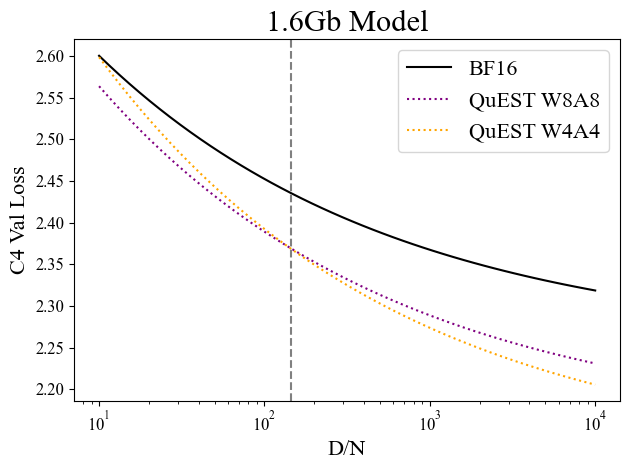

In [17]:
data_to_sizes = np.logspace(1, 4, base=10)

bf16_losses = []
quest8_losses = []
quest4_losses = []
quest48_losses = []

bf_params = 800e6

for data_to_size in data_to_sizes:
    data = bf_params * data_to_size
    
    bf16_loss = model(best_result.x, bf_params, data, 16)
    bf16_losses.append(bf16_loss)
    
    quest8_loss = model(best_result.x, bf_params * 2, data / 2, 8)
    quest8_losses.append(quest8_loss)
    
    quest4_loss = model(best_result.x, bf_params * 4, data / 4, 4)
    quest4_losses.append(quest4_loss)
    
    quest48_loss = model(best_result.x, bf_params * 8.0, data / 8.0, 2.5)
    quest48_losses.append(quest48_loss)
    
plt.plot(data_to_sizes, bf16_losses, label="BF16", color=colors[16], linestyle=linestyles["NoQuantizer"])
plt.plot(data_to_sizes, quest8_losses, label="QuEST W8A8", color=colors[8], linestyle=linestyles["HadamardTrustQuantizer"])
plt.plot(data_to_sizes, quest4_losses, label="QuEST W4A4", color=colors[4], linestyle=linestyles["HadamardTrustQuantizer"])
# plt.plot(data_to_sizes, quest48_losses, label="QuEST 2:4", color=colors[4], linestyle=linestyles["HadamardFourEightTrustQuantizer"])

plt.axvline(data_to_sizes[np.argmin(np.abs(np.array(quest8_losses) - np.array(quest4_losses)))], color="grey", linestyle="--")
# plt.axvline(data_to_sizes[np.argmin(np.abs(np.array(quest48_losses) - np.array(quest4_losses)))], color="grey", linestyle="--")

plt.xlabel("D/N")
plt.xscale("log")
plt.ylabel("C4 Val Loss")

plt.title(f"{bf_params * 2e-9:.1f}Gb Model", fontsize=22)

plt.legend()
plt.tight_layout()
plt.savefig("../figures/isomem.pdf", bbox_inches='tight')

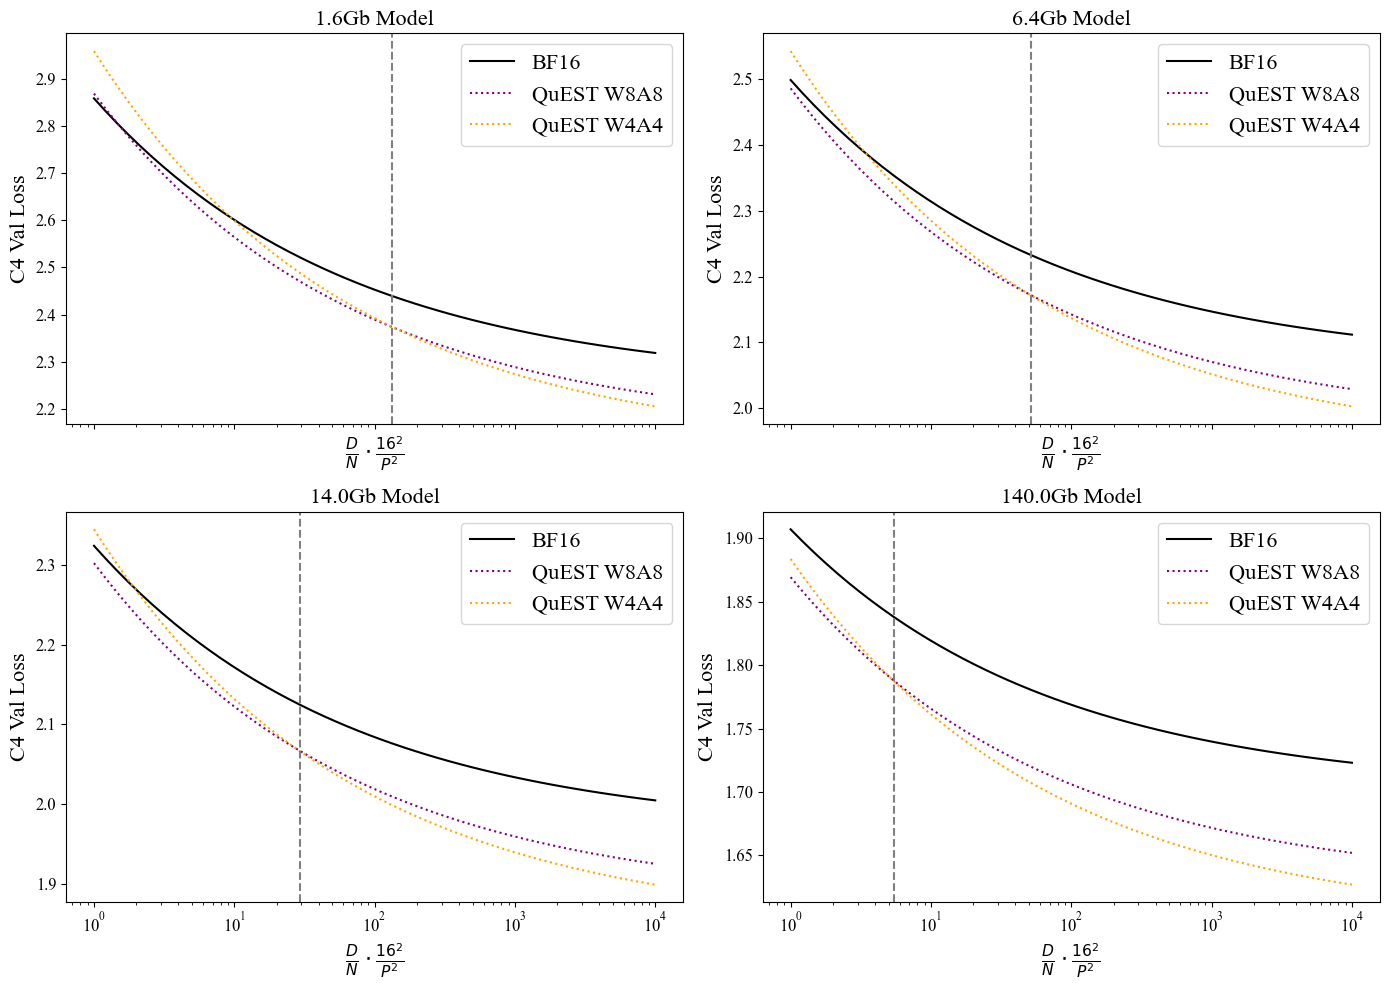

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example definitions or placeholders:
# best_result.x = [...]
# def model(x, N, data_size, bits): return some_loss_value
# colors = {16: 'blue', 8: 'orange', 4: 'green'}
# linestyles = {"NoQuantizer": "-", "HadamardTrustQuantizer": "--", "HadamardFourEightTrustQuantizer": ":"}

bf_params_list = [800e6, 3.2e9, 7e9, 70e9]  # 800M, 3.2B, 7B, 70B
data_to_sizes = np.logspace(0, 4, base=10)  # D/N values on x-axis

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, bf_params in zip(axes.flatten(), bf_params_list):
    bf16_losses = []
    quest8_losses = []
    quest4_losses = []
    quest48_losses = []
    
    for dts in data_to_sizes:
        data = bf_params * dts
        
        bf16_loss = model(best_result.x, bf_params,       data,       16)
        quest8_loss = model(best_result.x, bf_params * 2, data / 2,   8)
        quest4_loss = model(best_result.x, bf_params * 4, data / 4,   4)
        quest48_loss = model(best_result.x, bf_params * 8, data / 8, 2.5)  # QuEST 2:4 if needed
        
        bf16_losses.append(bf16_loss)
        quest8_losses.append(quest8_loss)
        quest4_losses.append(quest4_loss)
        quest48_losses.append(quest48_loss)
    
    # Plot curves:
    ax.plot(data_to_sizes, bf16_losses,   label="BF16",
            color=colors[16], linestyle=linestyles["NoQuantizer"])
    ax.plot(data_to_sizes, quest8_losses, label="QuEST W8A8",
            color=colors[8],  linestyle=linestyles["HadamardTrustQuantizer"])
    ax.plot(data_to_sizes, quest4_losses, label="QuEST W4A4",
            color=colors[4],  linestyle=linestyles["HadamardTrustQuantizer"])
    # If you want to include the QuEST 2:4 line, uncomment:
    # ax.plot(data_to_sizes, quest48_losses, label="QuEST 2:4",
    #         color=colors[4], linestyle=linestyles["HadamardFourEightTrustQuantizer"])

    # Vertical line for when QuEST W8A8 ~ QuEST W4A4
    arg_min = np.argmin(np.abs(np.array(quest8_losses) - np.array(quest4_losses)))
    ax.axvline(data_to_sizes[arg_min], color="grey", linestyle="--")
    
    ax.set_xscale("log")
    ax.set_xlabel(r"$\frac{D}{N}\cdot\frac{16^2}{P^2}$")
    ax.set_ylabel("C4 Val Loss")
    
    # Convert 'bf_params * 2e-9' into GB (or Gb) for the title:
    title_val = bf_params * 2e-9  # original snippet used 2e-9 scaling
    ax.set_title(f"{title_val:.1f}Gb Model", fontsize=16)
    
    ax.legend()

plt.tight_layout()
plt.savefig("../figures/isomem.pdf", bbox_inches='tight')
plt.show()


In [19]:
HadamardTrustSimilarities = {'model.transformer.h.5.mlp.c_proj': {'mean': 0.98828125, 'std': 0.0771484375},
 'model.transformer.h.5.attn.c_proj': {'mean': 0.98046875,
  'std': 0.07275390625},
 'model.transformer.h.4.mlp.c_proj': {'mean': 0.953125, 'std': 0.09912109375},
 'model.transformer.h.4.attn.c_proj': {'mean': 0.9453125,
  'std': 0.10107421875},
 'model.transformer.h.3.mlp.c_proj': {'mean': 0.93359375, 'std': 0.103515625},
 'model.transformer.h.3.attn.c_proj': {'mean': 0.921875, 'std': 0.1103515625},
 'model.transformer.h.2.mlp.c_proj': {'mean': 0.90625, 'std': 0.1220703125},
 'model.transformer.h.2.attn.c_proj': {'mean': 0.90234375,
  'std': 0.12255859375},
 'model.transformer.h.1.mlp.c_proj': {'mean': 0.89453125, 'std': 0.119140625},
 'model.transformer.h.1.attn.c_proj': {'mean': 0.8828125, 'std': 0.1328125},
 'model.transformer.h.0.mlp.c_proj': {'mean': 0.875, 'std': 0.1328125},
 'model.transformer.h.0.attn.c_proj': {'mean': 0.828125, 'std': 0.1865234375}}

TrustSimilarities = {'model.transformer.h.5.mlp.c_proj': {'mean': 0.76171875, 'std': 0.150390625},
 'model.transformer.h.5.attn.c_proj': {'mean': 0.515625, 'std': 0.17578125},
 'model.transformer.h.4.mlp.c_proj': {'mean': 0.3671875, 'std': 0.1875},
 'model.transformer.h.4.attn.c_proj': {'mean': 0.3046875, 'std': 0.16015625},
 'model.transformer.h.3.mlp.c_proj': {'mean': 0.2431640625,
  'std': 0.1474609375},
 'model.transformer.h.3.attn.c_proj': {'mean': 0.208984375,
  'std': 0.1298828125},
 'model.transformer.h.2.mlp.c_proj': {'mean': 0.1630859375,
  'std': 0.12451171875},
 'model.transformer.h.2.attn.c_proj': {'mean': 0.146484375,
  'std': 0.11279296875},
 'model.transformer.h.1.mlp.c_proj': {'mean': 0.126953125,
  'std': 0.1103515625},
 'model.transformer.h.1.attn.c_proj': {'mean': 0.109375, 'std': 0.09912109375},
 'model.transformer.h.0.mlp.c_proj': {'mean': 0.08935546875,
  'std': 0.0927734375},
 'model.transformer.h.0.attn.c_proj': {'mean': 0.053466796875,
  'std': 0.0966796875}}

STESimilarities = {'model.transformer.h.5.mlp.c_proj': {'mean': 0.7980809807777405,
  'std': 0.19133338332176208},
 'model.transformer.h.5.attn.c_proj': {'mean': 0.47584787011146545,
  'std': 0.18935102224349976},
 'model.transformer.h.4.mlp.c_proj': {'mean': 0.34503230452537537,
  'std': 0.1870272308588028},
 'model.transformer.h.4.attn.c_proj': {'mean': 0.22640655934810638,
  'std': 0.16238078474998474},
 'model.transformer.h.3.mlp.c_proj': {'mean': 0.16447949409484863,
  'std': 0.14397986233234406},
 'model.transformer.h.3.attn.c_proj': {'mean': 0.10793957114219666,
  'std': 0.14472198486328125},
 'model.transformer.h.2.mlp.c_proj': {'mean': 0.07829369604587555,
  'std': 0.11807195842266083},
 'model.transformer.h.2.attn.c_proj': {'mean': 0.062155239284038544,
  'std': 0.14942869544029236},
 'model.transformer.h.1.mlp.c_proj': {'mean': 0.04646104946732521,
  'std': 0.15194371342658997},
 'model.transformer.h.1.attn.c_proj': {'mean': 0.037694450467824936,
  'std': 0.24229077994823456},
 'model.transformer.h.0.mlp.c_proj': {'mean': 0.033532772213220596,
  'std': 0.24056945741176605},
 'model.transformer.h.0.attn.c_proj': {'mean': 0.008873962797224522,
  'std': 0.5503823757171631}}

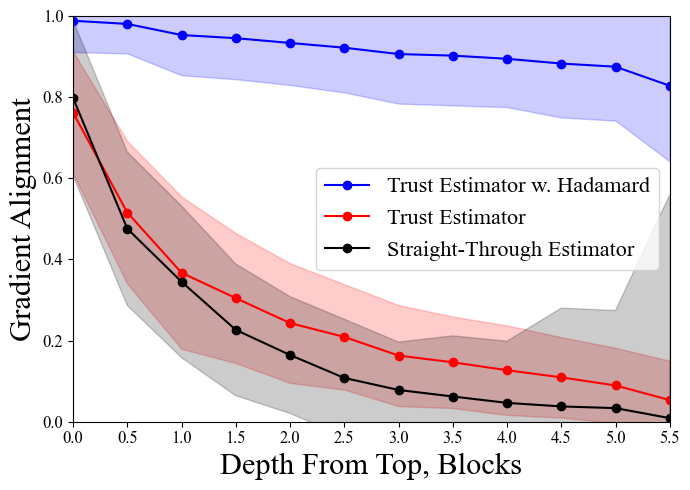

In [20]:
import numpy as np

def depth_from_name(name):
    idx = int(name.split(".")[3])
    depth = 5 - idx
    if "attn" in name:
        depth += 0.5
    return depth


# Your provided data
data = HadamardTrustSimilarities

# Initialize lists to store processed data
x_values = []
means = []
stds = []

# Process each key to extract 'n' and compute '6 - n'
for key, values in data.items():
    # Extract 'n' from the key using string manipulation
    # Assuming the key format is consistent
    x = depth_from_name(key)
    x_values.append(x)
    means.append(values['mean'])
    stds.append(values['std'])

# Sort the data based on x_values to ensure the plot is ordered
sorted_indices = np.argsort(x_values)
x_sorted = np.array(x_values)[sorted_indices]
means_sorted = np.array(means)[sorted_indices]
stds_sorted = np.array(stds)[sorted_indices]

# Create the plot
plt.figure(figsize=(7, 5))
plt.plot(x_sorted, means_sorted, marker='o', linestyle='-', color='blue', label='Trust Estimator w. Hadamard')

# Using a shaded region to represent ±1 std
plt.fill_between(
    x_sorted,
    means_sorted - stds_sorted,
    means_sorted + stds_sorted,
    color='blue',
    alpha=0.2,
)


# Your provided data
data = TrustSimilarities

# Initialize lists to store processed data
x_values = []
means = []
stds = []

# Process each key to extract 'n' and compute '6 - n'
for key, values in data.items():
    # Extract 'n' from the key using string manipulation
    # Assuming the key format is consistent
    x = depth_from_name(key)
    x_values.append(x)
    means.append(values['mean'])
    stds.append(values['std'])

# Sort the data based on x_values to ensure the plot is ordered
sorted_indices = np.argsort(x_values)
x_sorted = np.array(x_values)[sorted_indices]
means_sorted = np.array(means)[sorted_indices]
stds_sorted = np.array(stds)[sorted_indices]

# Create the plot
plt.plot(x_sorted, means_sorted, marker='o', linestyle='-', color='red', label='Trust Estimator')

# Using a shaded region to represent ±1 std
plt.fill_between(
    x_sorted,
    means_sorted - stds_sorted,
    means_sorted + stds_sorted,
    color='red',
    alpha=0.2,
)


# Your provided data
data = STESimilarities

# Initialize lists to store processed data
x_values = []
means = []
stds = []

# Process each key to extract 'n' and compute '6 - n'
for key, values in data.items():
    # Extract 'n' from the key using string manipulation
    # Assuming the key format is consistent
    x = depth_from_name(key)
    x_values.append(x)
    means.append(values['mean'])
    stds.append(values['std'])

# Sort the data based on x_values to ensure the plot is ordered
sorted_indices = np.argsort(x_values)
x_sorted = np.array(x_values)[sorted_indices]
means_sorted = np.array(means)[sorted_indices]
stds_sorted = np.array(stds)[sorted_indices]

# Create the plot
plt.plot(x_sorted, means_sorted, marker='o', linestyle='-', color='black', label='Straight-Through Estimator')

# Using a shaded region to represent ±1 std
plt.fill_between(
    x_sorted,
    means_sorted - stds_sorted,
    means_sorted + stds_sorted,
    color='black',
    alpha=0.2,
)


# Customize the plot
plt.xlabel('Depth From Top, Blocks', fontsize=22)
plt.ylabel('Gradient Alignment', fontsize=22)
plt.xticks(x_sorted)  # Ensure x-axis has integer ticks corresponding to (6 - n)
plt.ylim(0, 1)
plt.xlim(0, 5.5)
plt.legend(fontsize=16)
plt.tight_layout()

# Display the plot
plt.savefig("../figures/gradient_alignment.pdf")
plt.show()


# MASKS

In [21]:
hadamard_trust_mask_proportion = {0: 9.036064147949219e-05,
 500: 0.00012940168380737305,
 1000: 8.547306060791016e-05,
 1500: 9.518861770629883e-05,
 2000: 0.00012451410293579102,
 2500: 0.00013184547424316406,
 3000: 0.00012451410293579102,
 3500: 0.0001391768455505371,
 4000: 0.0001513957977294922,
 4500: 0.0001513957977294922,
 5000: 0.00014895200729370117,
 5500: 0.00017577409744262695,
 6000: 0.00010251998901367188,
 6500: 0.0001220703125,
 7000: 0.00011473894119262695,
 7500: 0.00011229515075683594,
 8000: 0.00012940168380737305,
 8500: 0.0001220703125,
 9000: 0.00011718273162841797,
 9500: 8.791685104370117e-05,
 10000: 9.763240814208984e-05,
 10500: 8.058547973632812e-05,
 11000: 9.036064147949219e-05}

trust_mask_proportion = {0: 0.00011962652206420898,
 500: 0.0002294778823852539,
 1000: 0.00022214651107788086,
 1500: 0.0002588033676147461,
 2000: 0.000363767147064209,
 2500: 0.0003955364227294922,
 3000: 0.00043213367462158203,
 3500: 0.00045412778854370117,
 4000: 0.00048094987869262695,
 4500: 0.000493168830871582,
 5000: 0.0005199909210205078,
 5500: 0.0005248785018920898,
 6000: 0.000554203987121582,
 6500: 0.0005713105201721191,
 7000: 0.0005297660827636719,
 7500: 0.0004980564117431641,
 8000: 0.000495612621307373,
 8500: 0.000485837459564209,
 9000: 0.00048094987869262695,
 9500: 0.0004711747169494629,
 10000: 0.00046384334564208984,
 10500: 0.0004419088363647461,
 11000: 0.00043457746505737305}

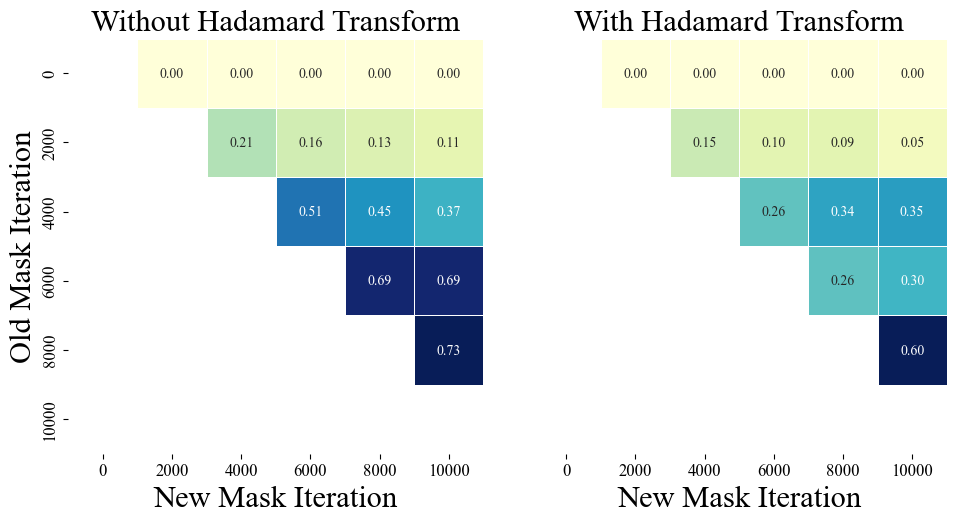

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


# Create a figure and a heatmap
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

causal_df = pd.read_csv("../for_plots/masks.csv", index_col=0)
mask_visual = causal_df.isna()
sns.heatmap(
    causal_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=.5,
    square=True,
    cbar=False,
    ax=axs[0]
)
axs[0].set_title("Without Hadamard Transform", fontsize=22)

# Customize labels and layout
axs[0].set_xlabel("New Mask Iteration", fontsize=22)
axs[0].set_ylabel("Old Mask Iteration", fontsize=22)

causal_df = pd.read_csv("../for_plots/hadamard_masks.csv", index_col=0)
mask_visual = causal_df.isna()
sns.heatmap(
    causal_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=.5,
    square=True,
    cbar=False,
    ax=axs[1]
)
axs[1].set_title("With Hadamard Transform", fontsize=22)

# Customize labels and layout
axs[1].set_xlabel("New Mask Iteration", fontsize=22)

# delete y ticks
axs[1].set_yticks([])
axs[1].set_ylabel("")

fig.tight_layout()
fig.savefig("../figures/masks_persistency.pdf", bbox_inches='tight')
# Display the plot
plt.show()


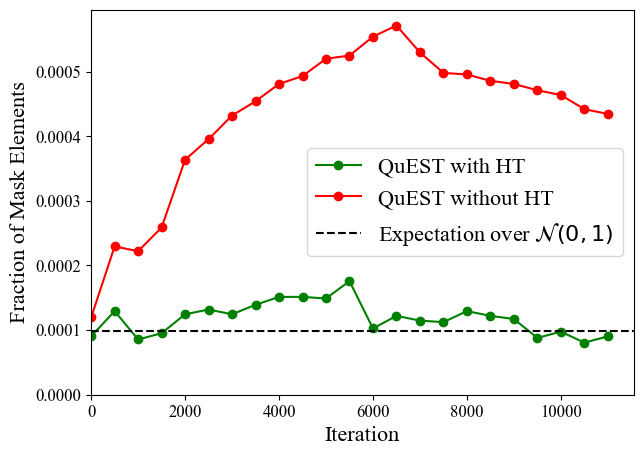

In [23]:
plt.figure(figsize=(7, 5))

plt.plot(hadamard_trust_mask_proportion.keys(), hadamard_trust_mask_proportion.values(), label="QuEST with HT", marker="o", color="green")
plt.plot(trust_mask_proportion.keys(), trust_mask_proportion.values(), label="QuEST without HT", marker="o", color="red")
plt.axhline(2 * norm.sf(3.884938678807525 * (1 + 1 / 255 / 2)), color="black", linestyle="--", label=r"Expectation over $\mathcal{N}(0, 1)$")

plt.xlim(0, None)
plt.xlabel("Iteration")

plt.ylim(0, None)
plt.ylabel(r"Fraction of Mask Elements")

plt.legend()
plt.savefig("../figures/mask_proportion.pdf", bbox_inches='tight')

plt.show()